In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import operator
import nltk
import sklearn
import h5py
from sklearn.model_selection import train_test_split
from IPython.display import display

In [94]:
data_raw = pd.read_csv('train.csv')

In [3]:
data_raw.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [4]:
identity_columns = ['asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 
                    'heterosexual', 'hindu',
                    'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
                    'jewish', 'latino', 'male', 'muslim', 'other_disability',
                    'other_gender', 'other_race_or_ethnicity', 'other_religion',
                    'other_sexual_orientation', 'physical_disability',
                    'psychiatric_or_mental_illness', 'transgender', 'white']
identity_columns2 = ['_asian', '_atheist', '_bisexual', '_black', '_buddhist', 
                     '_christian', '_female', '_heterosexual', '_hindu','_homosexual_gay_or_lesbian', 
                     '_intellectual_or_learning_disability','_jewish', '_latino', '_male', 
                     '_muslim', '_other_disability','_other_gender', '_other_race_or_ethnicity', 
                     '_other_religion','_other_sexual_orientation', '_physical_disability',
                     '_psychiatric_or_mental_illness', '_transgender', '_white']
keep = ['comment_text','asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']

In [96]:
data_raw = data_raw.dropna()
y = data_raw.target
X = data_raw[keep]

In [95]:
data_raw.shape

(1804874, 45)

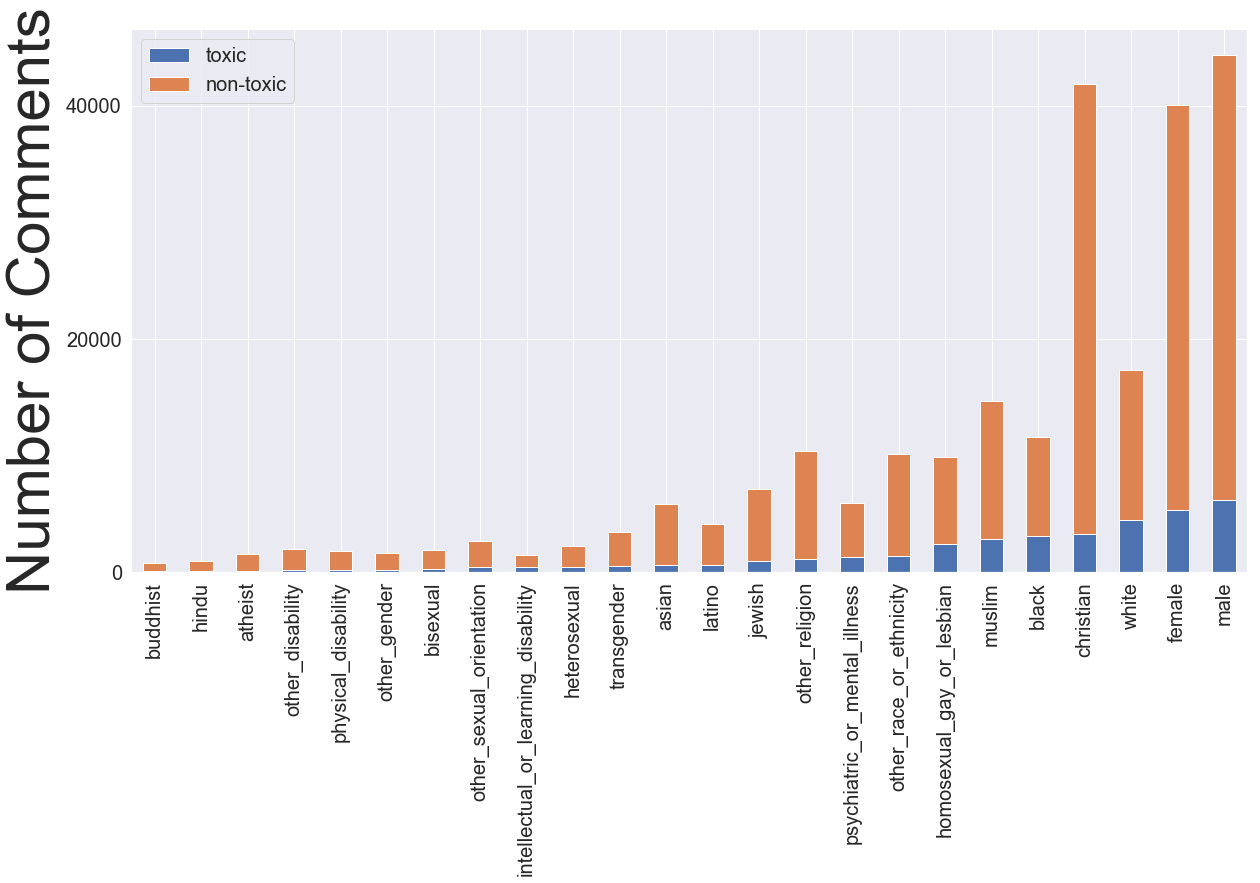

In [75]:
X_labeled = data_raw.loc[:, ['target'] + identity_columns ].dropna()
toxic_df = X_labeled[X_labeled['target'] >= .5][identity_columns]
non_toxic_df = X_labeled[X_labeled['target'] < .5][identity_columns]
toxic_count = toxic_df.where(X_labeled == 0, other = 1).sum()
non_toxic_count = non_toxic_df.where(X_labeled == 0, other = 1).sum()
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
plot = toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(20,10), fontsize=20)
plot.set_ylabel("Number of Comments")
plot.legend(prop={'size': 20})
plt.savefig('1.png')

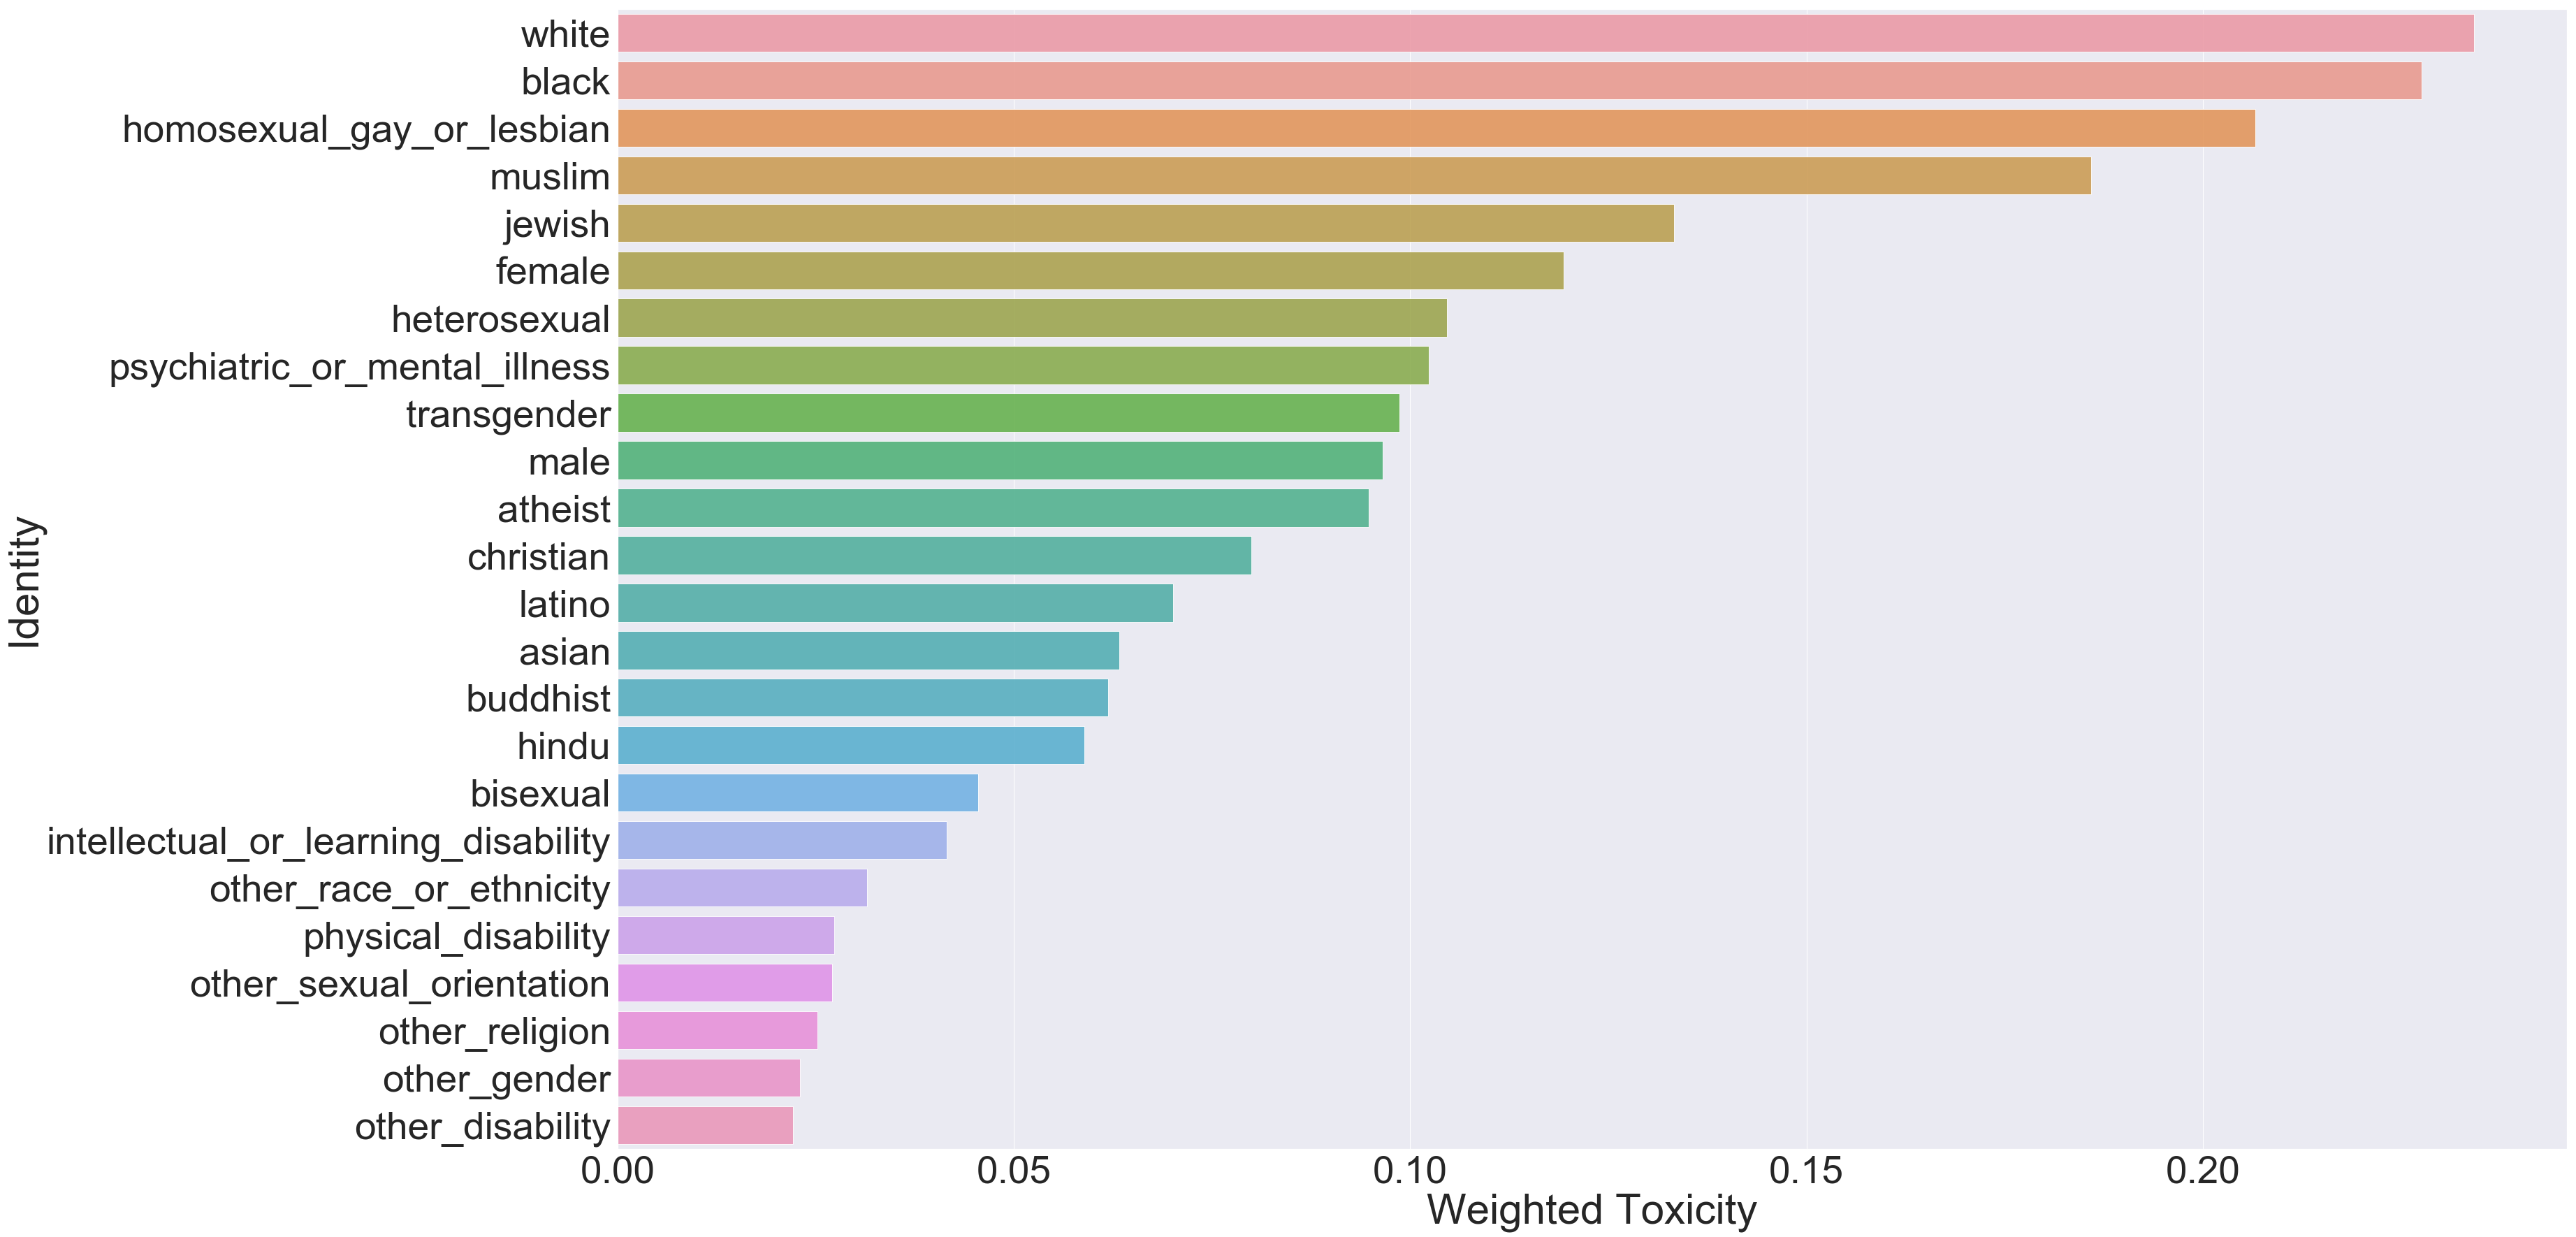

In [7]:
import seaborn as sns

weighted_toxic = X_labeled.iloc[:, 1:].multiply(X_labeled.iloc[:, 0], axis="index").sum() 
identity_label_count = X_labeled[identity_columns].where(X_labeled == 0, other = 1).sum()
weighted_toxic = weighted_toxic/identity_label_count
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(50,30))
sns.set(font_scale=5)
ax = sns.barplot(x = weighted_toxic.values , y = weighted_toxic.index, alpha=0.85)
plt.ylabel('Identity')
plt.xlabel('Weighted Toxicity')
plt.show()

In [9]:
from collections import Counter
import spacy
import nltk
import re
import string
from nltk.corpus import stopwords

# tokenize with spacy
nlp = spacy.load('en')

#
#data_raw['tokens'] = [nlp(text, # disable parts of the language processing pipeline we don't need here to speed up processing
#                    disable=['ner', # named entity recognition
#                                   'tagger', # part-of-speech tagger
#                                   'textcat', # document label categorizer
#                                  ]) for text in data_raw.comment_text]

punctuations = string.punctuation
stop_words = set(stopwords.words("english"))

def cleanup_text(docs):
    texts = []
    for doc in docs:
        doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
        doc = nlp(doc, disable=['ner', 'tagger', 'textcat'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

rows_toxic = toxic_df.index.tolist()
rows_nontoxic = non_toxic_df.index.tolist()

Xtoxic = data_raw.loc[rows_toxic]
Xnotoxic = data_raw.loc[rows_nontoxic]

# you can choose toxicity here
#toxic_text = [text for text in Xtoxic[Xtoxic['target'] == 1]['comment_text']]

toxic_text = [text for text in Xtoxic ['comment_text']]
nontoxic_text = [text for text in Xnotoxic ['comment_text']]

toxic_clean = cleanup_text(toxic_text)
toxic_clean = ' '.join(toxic_clean).split()

nontoxic_clean = cleanup_text(nontoxic_text)
nontoxic_clean = ' '.join(nontoxic_clean).split()

In [10]:
toxic_counts = Counter(toxic_clean)
nontoxic_counts = Counter(nontoxic_clean)

toxic_common_words = [word[0] for word in toxic_counts.most_common(20)]
toxic_common_counts = [word[1] for word in toxic_counts.most_common(20)]

In [41]:
toxic_common_counts

[6414,
 6158,
 5084,
 5018,
 4765,
 4438,
 4362,
 4210,
 4081,
 4009,
 3985,
 3705,
 3523,
 3497,
 3445,
 2805,
 2531,
 2380,
 2353,
 2184]

In [45]:
#return the counts of the toxic_common_words in nontoxic_counts (this is the number of times the 'toxic' words come up in non-toxic contexts
for current in toxic_common_words:
    for word in nontoxic_counts.most_common(500):
        if current == word[0]:
            print(str(current) + ' ' + str(word[1]))
            
nontoxic_common_counts = [43727, 15986, 33041, 48601, 20479, 37082, 34408, 29086, 40501, 23308, 9061, 32535, 29876, 29292, 28325, 24181, 19710, 4132, 22228, 19162]


people 43727
white 15986
like 33041
would 48601
trump 20479
say 37082
get 34408
woman 29086
one 40501
man 23308
black 9061
make 32535
think 29876
go 29292
know 28325
right 24181
want 19710
racist 4132
see 22228
even 19162
[43727, 15986, 33041, 48601, 20479, 37082, 34408, 29086, 40501, 23308, 9061, 32535, 29876, 29292, 28325, 24181, 19710, 4132, 22228, 19162]
[['people', 'white', 'like', 'would', 'trump', 'say', 'get', 'woman', 'one', 'man', 'black', 'make', 'think', 'go', 'know', 'right', 'want', 'racist', 'see', 'even'], [6414, 6158, 5084, 5018, 4765, 4438, 4362, 4210, 4081, 4009, 3985, 3705, 3523, 3497, 3445, 2805, 2531, 2380, 2353, 2184], [43727, 15986, 33041, 48601, 20479, 37082, 34408, 29086, 40501, 23308, 9061, 32535, 29876, 29292, 28325, 24181, 19710, 4132, 22228, 19162]]


        toxicCount  nontoxicCount  toxicpercent
word                                           
people        6414          43727      0.127919
white         6158          15986      0.278089
like          5084          33041      0.133351
would         5018          48601      0.093586
trump         4765          20479      0.188758
say           4438          37082      0.106888
get           4362          34408      0.112510
woman         4210          29086      0.126442
one           4081          40501      0.091539
man           4009          23308      0.146758
black         3985           9061      0.305458
make          3705          32535      0.102235
think         3523          29876      0.105482
go            3497          29292      0.106652
know          3445          28325      0.108436
right         2805          24181      0.103943
want          2531          19710      0.113799
racist        2380           4132      0.365479
see           2353          22228      0

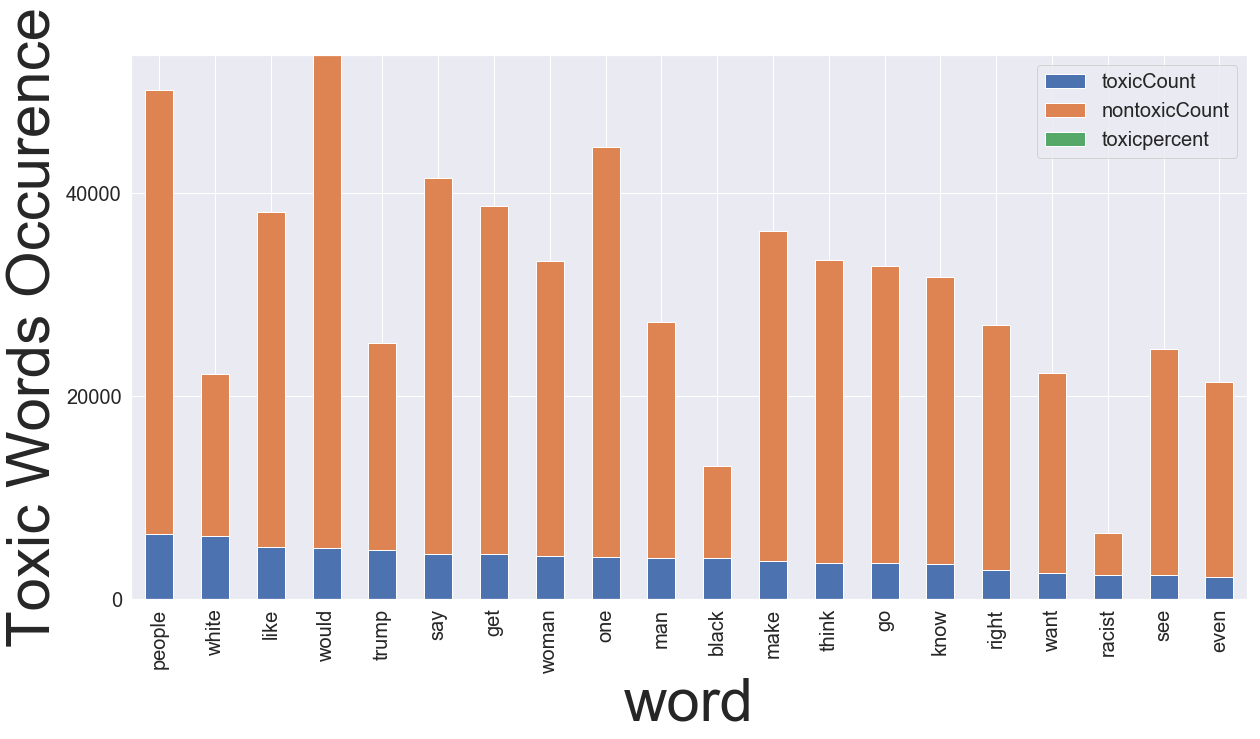

In [78]:
toxic_occurence = [toxic_common_words, toxic_common_counts, nontoxic_common_counts]

toxic_occurence = np.array(toxic_occurence)
occureDF = pd.DataFrame({'word':toxic_occurence[0,:],'toxicCount':toxic_occurence[1,:], 'nontoxicCount':toxic_occurence[2,:]})
occureDF.set_index("word",drop=True,inplace=True)

occureDF.toxicCount = occureDF.toxicCount.astype(int)
occureDF.nontoxicCount = occureDF.nontoxicCount.astype(int)
occureDF['toxicpercent'] = occureDF.toxicCount/(occureDF.toxicCount+occureDF.nontoxicCount)
print(occureDF)

plot = occureDF.sort_values(by='toxicCount', ascending=False).plot(kind='bar', stacked=True, figsize=(20,10), fontsize=20)
plot.set_ylabel("Toxic Words Occurence")
plot.legend(prop={'size': 20})

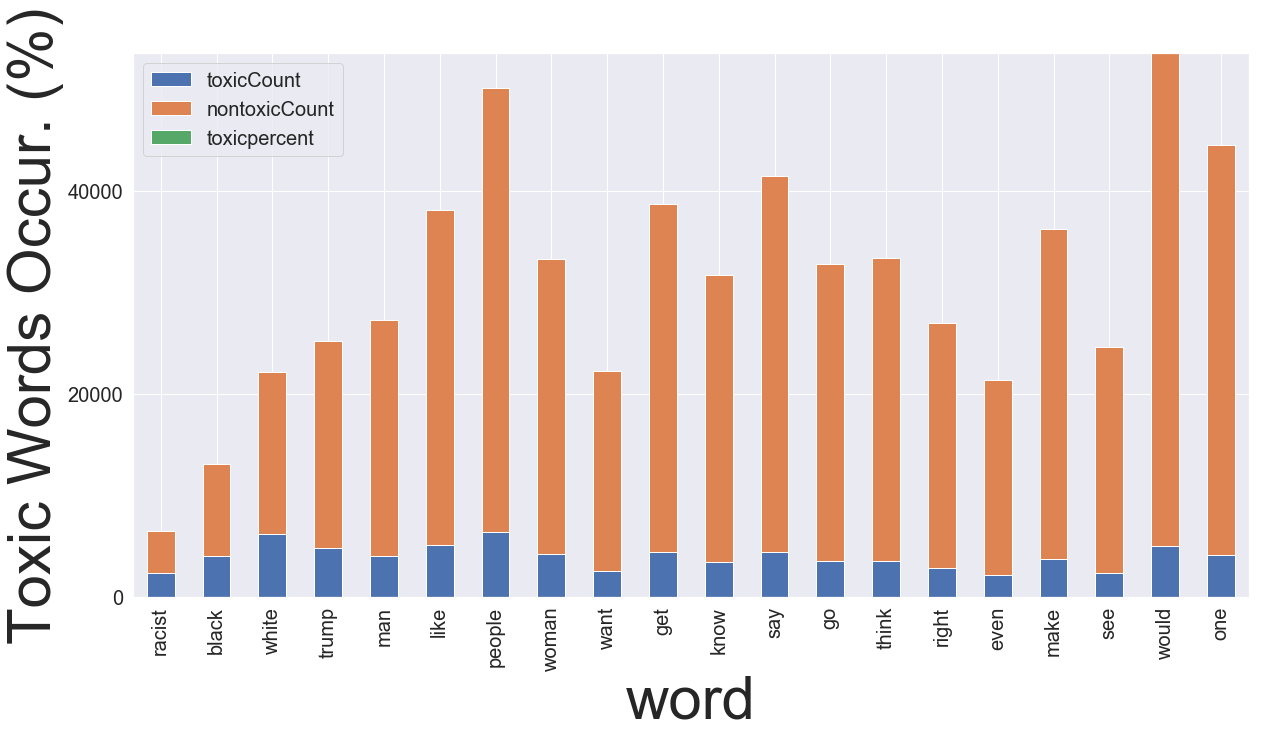

In [81]:
plot = occureDF.sort_values(by='toxicpercent', ascending=False).plot(kind='bar', stacked=True, figsize=(20,10), fontsize=20)
plot.set_ylabel("Toxic Words Occur. (%)")
plot.legend(prop={'size': 20})

In [83]:
toxic_counts.most_common(2)

[('people', 6414), ('white', 6158)]

In [84]:
len(nontoxic_counts)

143130

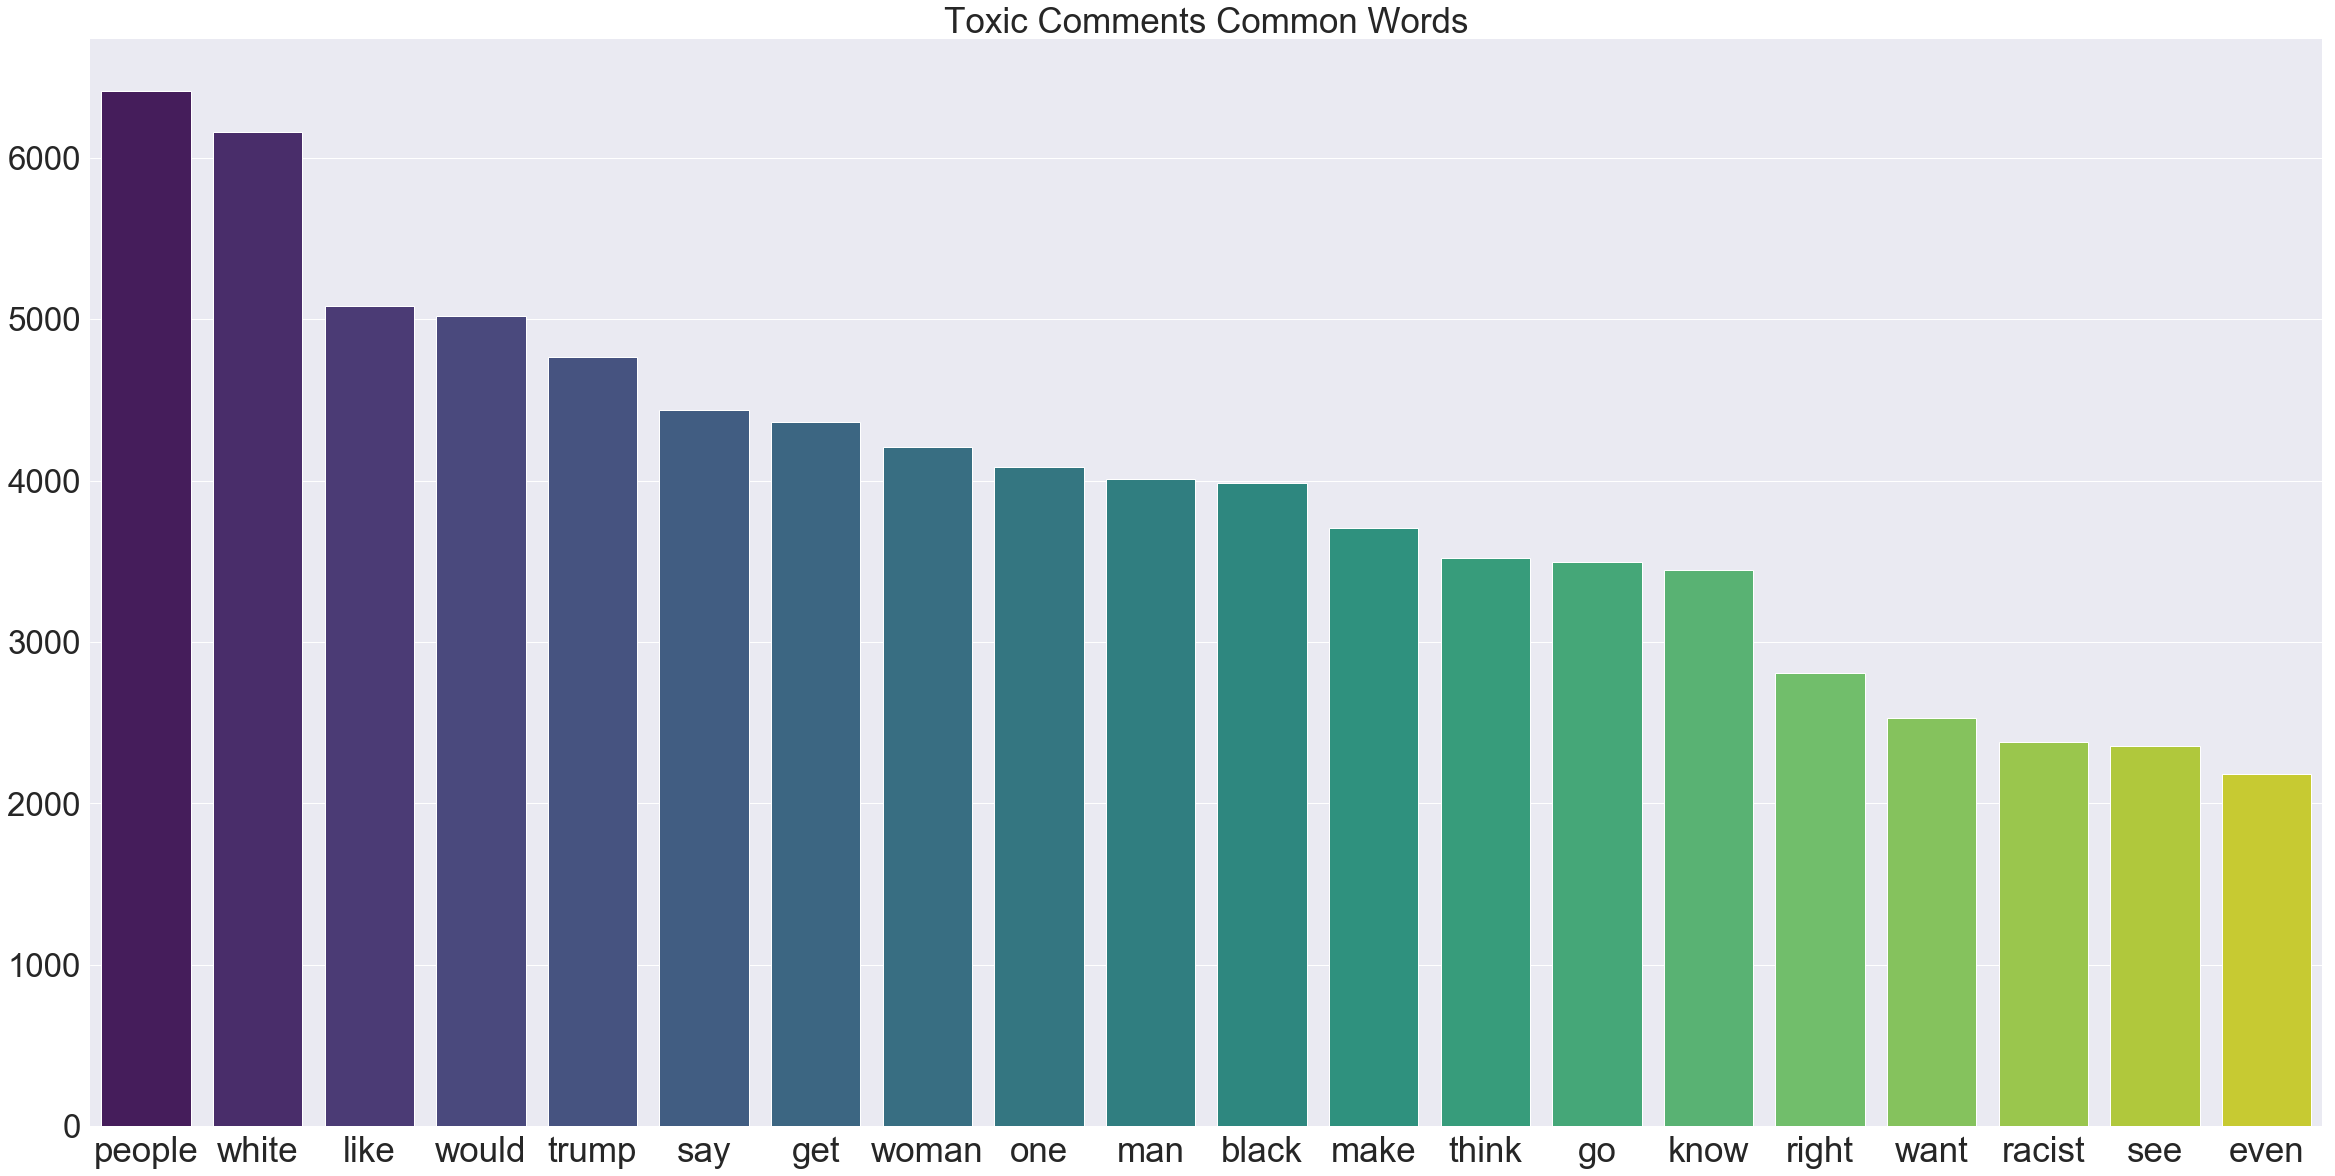

In [85]:
plt.figure(figsize=(40,20))
sns.set(font_scale=3)

ax2 = sns.barplot(toxic_common_words, toxic_common_counts, palette='viridis')
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Toxic Comments Common Words', fontsize=35)
plt.tick_params(axis='x', which='major', labelsize=35)
plt.show()